# LAB 1: Sketching
Authors: 

    Antoine Chatalic (antoine.chatalic@dibris.unige.it)
    
    Giacomo Meanti  (giacomo.meanti@gmail.com)


 - This lab addresses sketching as a way to make kernel ridge regression more efficient. We will look at the Nystrom approximation and Random Fourier Features.
 - The aim of the lab is to play with the libraries and to get a practical grasp of what was discussed in class.
 - Follow the instructions below.
 
 
**Goal**
This lab is divided in three parts depending of their level of complexity (Beginner,
Intermediate, Advanced). Your goal is to complete entirely, at least, one of the
three parts.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import time

import sklearn.metrics
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn import datasets, model_selection

from lab_utils import *

## The Kernel Matrix

### Data generation

Here a non-linear dataset is created with two classes and two dimensions. In this first section only the `X` variable will be used, and the class labels can be mostly ignored.

In [3]:
X, y = create_random_data(n_samples=1000, noise_level=.1, dataset="moons")
print("%d samples, %d features" % X.shape)

1000 samples, 2 features


In [4]:
print(f"A few data points: {X[:3]}")
print(f"A few labels: {y[:3]}")

A few data points: [[ 1.17640523  0.04001572]
 [ 1.09785398  0.23038506]
 [ 1.18667653 -0.08513657]]
A few labels: [-1 -1 -1]


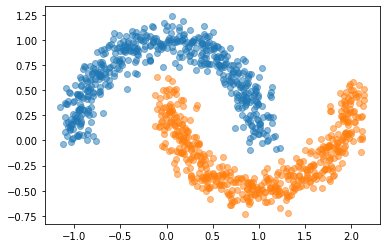

In [5]:
plot_dataset(X, y)

### Compute the full kernel

You will use the Gaussian kernel, which depends on the bandwidth hyperparameter ($\sigma$)
$$
    k(x_1, x_2) = \exp\Big(-\frac{1}{2\sigma^2} \lVert x_1 - x_2 \rVert^2 \Big)
$$

To compute the kernel matrix, we need to calculate the kernel function on every pair of points in `X`. 
We will use the [`pairwise_kernels`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html) function of sklearn for this task.

The first step is to write the kernel function, following the formula above. The function takes as inputs two points $x_1$ and $x_2$ from the dataset (both are in $\mathbb{R}^2$) and outputs a single number $k(x_1, x_2)$.


In [6]:
def gaussian_kernel(x1, x2):
    sigma = 1.0
    # TODO: Fill in the Gaussian kernel formula
    return np.exp((-1 / (2 * sigma ** 2)) * (np.linalg.norm(x1 - x2) ** 2))

Then the full kernel matrix is computed by passing the function you have defined to sklearn.

We are particularly interested in answering the following question:
 - *How long does it take to compute the full kernel?*
 
In python we can **time our code** by measuring the time before and after the code runs, and taking the difference:
```python
t_s = time.time()
### our code here ###
t_e = time.time()
elapsed_time = t_e - t_s
```

Try to do the same to measure the time to compute the full kernel below

In [7]:
# TODO: insert timing code
t_s = time.time()
full_kernel = sklearn.metrics.pairwise.pairwise_kernels(X, X, metric=gaussian_kernel)
# TODO: insert timing code
t_e = time.time()
full_kernel_time = t_e - t_s
print(f"Computing the kernel matrix (of size {full_kernel.shape}) completed in {full_kernel_time:.2f}s")

Computing the kernel matrix (of size (1000, 1000)) completed in 3.34s


The kernel matrix is computed between every pair of input points.
Its entries indicate the similarity between such points: higher values indicate higher similarity and viceversa.

By plotting the kernel matrix, the separation of the dataset into two classes is very clear: the first and second halves of the data belong to the first and second classes respectively. 
They have high internal similarity (similarity between points of the same class) and low external similarity (similarity to points of a different class).

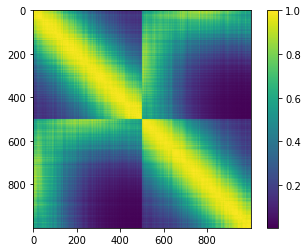

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(full_kernel)
fig.colorbar(im, ax=ax)

### Nystrom Sketching of the Kernel

Now for efficiency reasons, we want to avoid computing the whole kernel matrix. In particular, assume the following situation
$$
K = 
\begin{bmatrix}
A & S \\
S^\top & Q
\end{bmatrix}.
$$
We compute $A$ and $S$, but not $Q$. 
The Nystrom approximation tells us how to approximate the full kernel matrix using just $A$ and $S$:
$$
    K \approx [A \vert S]^\top A^{-1} [A \vert S]
$$
where $[A \vert S]$ indicates the concatenation of matrices $A$ and $S$.

You will follow these steps to implement the Nystrom approximation
 1. Shuffle the whole dataset, in order to obtain an unbiased sampling of the Nystrom centers
 2. Pick the Nystrom centers (the points with which $A$ is computed) by taking a subset of `m` points from the shuffled dataset `X`
 2. Compute the kernel between the Nystrom centers: `A`
 3. Compute the kernel between the Nystrom centers and the whole dataset (to form $[A \vert S]$)
 4. Use the Nystrom approximation formula to compute the approximate kernel.

In [9]:
shuffle_ids = np.random.permutation(X.shape[0])
X = X[shuffle_ids]

Recompute the full kernel on the shuffled dataset. It will also be reshuffled, but contain the same information as before.

In [10]:
full_kernel = sklearn.metrics.pairwise.pairwise_kernels(X, X, metric=gaussian_kernel)

In [11]:
m = 50
assert m <= X.shape[0], "Cannot take more Nystrom centers than the number of data points"

# Since the data is shuffled, to pick random Nystrom centers we can simply choose the first m points
nystrom_centers = X[:m]

Kernel between Nystrom centers

In [12]:
A = sklearn.metrics.pairwise.pairwise_kernels(
    nystrom_centers, nystrom_centers, metric=gaussian_kernel)
print(f"Kernel between Nystrom centers has shape {A.shape}")

Kernel between Nystrom centers has shape (50, 50)


Kernel between the Nystrom centers and the full dataset.

In [13]:
AS = sklearn.metrics.pairwise.pairwise_kernels(
    nystrom_centers, X, metric=gaussian_kernel)
print(f"Kernel between Nystrom centers and whole dataset has shape {AS.shape}")

Kernel between Nystrom centers and whole dataset has shape (50, 1000)


Nystrom approximation

In [14]:
approx_kernel = AS.T @ np.linalg.solve(A, AS)

Now plot the full and approximate kernel matrices and their difference. Notice that the two kernels are practically indistinguishable!
To be able to see the difference we must reduce the range of the visualization to between $-10^{-7}$ and $10^{-7}$.

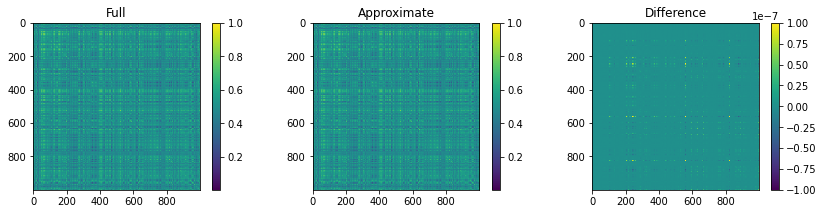

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
im = ax[0].imshow(full_kernel)
fig.colorbar(im, ax=ax[0])
ax[0].set_title("Full")
im = ax[1].imshow(approx_kernel)
fig.colorbar(im, ax=ax[1])
ax[1].set_title("Approximate")
im = ax[2].imshow(full_kernel - approx_kernel, vmin=-1e-7, vmax=1e-7)
fig.colorbar(im, ax=ax[2])
ax[2].set_title("Difference")
fig.tight_layout()

#### Quantitative evaluation of the Nystrom approximation

For a more scientific comparison we will put the code for the Nystrom approximation in a function, and perform the following analyses:
 - Compute the error of the Nystrom approximation with different values of `m`
 - Compare the timings of approximating the kernel vs. computing the full one.

The error we're interested in is the Frobenius norm of the difference between the full kernel matrix $K$ and the approximate kernel matrix $\tilde{K}$:
$$
    \lVert K - \tilde{K} \rVert_F = \sqrt{\sum_{i, j = 1}^n (K_{ij} - \tilde{K}_{ij})^2}
$$

We will define a function to compute it:

In [16]:
def kernel_approximation_error(full, approx):
    return np.sqrt(np.sum(np.square(full - approx)))

We also define a function to compute the Nystrom approximation. Fill in the blanks where appropriate.

In [17]:
def nystrom_approx(X, m):
    nystrom_centers = X[:m]
    # TODO: Fill in something?
    A = sklearn.metrics.pairwise.pairwise_kernels(
        nystrom_centers, nystrom_centers, metric=gaussian_kernel)
    AS = sklearn.metrics.pairwise.pairwise_kernels(
        nystrom_centers, X, metric=gaussian_kernel)
    approx_kernel = AS.T @ np.linalg.solve(A, AS)
    return approx_kernel

Now we run the analysis of error and timings for a list of different `m` values.
We also get the timing for the full kernel for plotting.

In [18]:
m_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200]
approx_errors = []
approx_timings = []
for m in m_list:
    t_s = time.time()
    approx_kernel = nystrom_approx(X, m)
    t_e = time.time()
    approx_errors.append(kernel_approximation_error(full_kernel, approx_kernel))
    approx_timings.append(t_e - t_s)
    print(f"{m} centers: error={approx_errors[-1]:.2e}  time={approx_timings[-1]:.2f}s")

10 centers: error=1.14e+01  time=0.11s
20 centers: error=5.26e-01  time=0.25s
30 centers: error=2.94e-03  time=0.29s
40 centers: error=2.04e-04  time=0.37s
50 centers: error=2.54e-05  time=0.60s
60 centers: error=5.03e-06  time=0.50s
70 centers: error=1.77e-06  time=0.59s
80 centers: error=5.26e-07  time=0.69s
90 centers: error=3.21e-07  time=0.79s
100 centers: error=6.36e-08  time=0.79s
120 centers: error=2.15e-08  time=0.94s
150 centers: error=1.60e-08  time=1.17s
200 centers: error=1.92e-09  time=1.50s


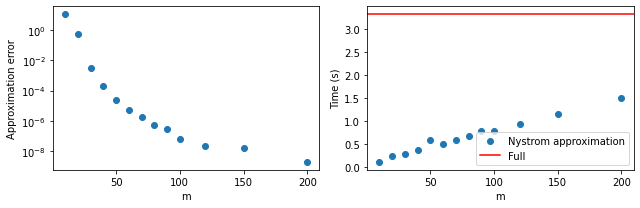

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
ax[0].scatter(m_list, approx_errors)
ax[0].set_xlabel("m")
ax[0].set_ylabel("Approximation error")
ax[0].set_yscale('log')
ax[1].scatter(m_list, approx_timings, label="Nystrom approximation")
ax[1].set_xlabel("m")
ax[1].set_ylabel("Time (s)")
ax[1].axhline(y=full_kernel_time, label="Full", c='r')
ax[1].legend()
fig.tight_layout()

## Sketching For Kernel Regression

### Kernel Ridge Regression

The kernel matrix is a crucial object in the kernel ridge regression (KRR) algorithm for supervised learning.

KRR consists of solving a linear regression problem in a infinite dimensional reproducing kernel Hilbert space (RKHS). 
The problem is reformulated as a finite-dimensional linear system which involves the kernel matrix, where the kernel function is the one defining the specific RKHS.

In practice, denote the RKHS $\mathcal{H}$, for example defined by the Gaussian kernel we have used above. Denote the dataset by $X = \{x_i\}_{i=1}^n$ and $Y = \{y_i\}_{i=1}^n$.
To ensure uniqueness of the solution we must add a positive regularizer, controlled by hyperparameter $\lambda > 0$, which pushes solutions to zero.

$$
 \hat{f} = \arg\min_{f\in\mathcal{H}} \sum_{i=1}^n (f(x_i) - y_i)^2 + \lambda \lVert f \rVert
$$

By the representer theorem, every $f\in\mathcal{H}$ can be written as 
$$
    f(x) = \sum_{i=1}^n \alpha_i k(x, x_i)
$$
for some vector $\alpha\in\mathbb{R}^n$. From this it is possible to derive the expression for the norm of $f$:
$\lVert f \rVert = \alpha^\top K \alpha$.

Putting everything together, you can differentiate the objective and setting the derivative to zero obtain a closed-form for $\hat{f}$. This closed-form is what we will write down in code to solve KRR:

$$
\hat{f}(x) = k(x, X) \hat{\alpha}, \quad \hat{\alpha} = (K + \lambda I)^{-1} Y
$$


Once again we rely on the two moons dataset, with a bit more noise this time.

In [20]:
X, y = create_random_data(n_samples=2000, noise_level=.3, dataset="moons")
print("%d samples, %d features" % X.shape)

2000 samples, 2 features


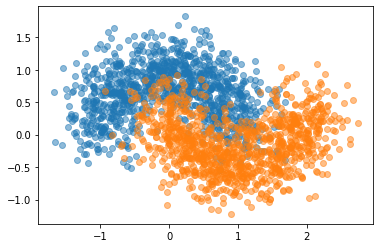

In [21]:
plot_dataset(X, y)

In order to evaluate supervised learning models, it is necessary to do so on **held-out data** which has not been used for training.
We used the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from scikit-learn to create a training set and a test set, both with 1000 samples.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True, random_state=42)

The hyperparameters for KRR need to be set a priori. Here the following values yield good results, but feel free to experiment with them.

In [23]:
kernel_bandwidth = 1.0
regularization = 1e-6

The following function computes the **classification error** of a model's predictions.
The models we consider always output a real number, and the labels in the moons dataset are always in $\{-1, +1\}$.
The classification error is computed by comparing the labels to the **sign** of the predictions.

In [24]:
def binary_classif_error(y_true, y_pred):
    return np.mean(np.sign(y_pred) != y_true)

#### Define a class which contains the KRR model.

The input parameters are:
 - the **kernel bandwidth**
 - the amount of **regularization** 
which we have seen above.

You might notice that the way the kernel matrix is computed changes slightly: 
 - we use the `"rbf"` metric predefined in scikit-learn 
 - the metric does not use parameter $\sigma$ but $\gamma = 1/2\sigma^2$.
 
This is much faster than passing our own function, otherwise the kernel computation becomes the bottleneck.

You should fill in the blanks. Solving a linear system can be done with the [np.linalg.solve](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) function from numpy.

In [25]:
class KernelRidge:
    def __init__(self, kernel_bandwidth, regularization):
        self.kernel_gamma = 1 / (2 * kernel_bandwidth ** 2)
        self.regularization = regularization
    
    def fit(self, X, y):
        K = sklearn.metrics.pairwise.pairwise_kernels(
            X, X, metric="rbf", gamma=self.kernel_gamma)
        reg_K = K + self.regularization * np.eye(X.shape[0])
        alpha = np.linalg.solve(reg_K, y)
        
        self.alpha_ = alpha
        self.X_ = X
        return self
    
    def predict(self, X_test):
        k_predict = sklearn.metrics.pairwise.pairwise_kernels(
            X_test, self.X_, metric="rbf", gamma=self.kernel_gamma)
        return k_predict @ self.alpha_

The following cell shows 
 - how to initialize the model, 
 - fit it to some training data,
 - make predictions
 - calculate the error

A plot of the predictions shows where the model makes mistakes.

In [26]:
krr_model = KernelRidge(kernel_bandwidth, regularization)
krr_model.fit(X_train, y_train);

pred_train = krr_model.predict(X_train)
pred_test = krr_model.predict(X_test)

krr_train_err = binary_classif_error(y_train, pred_train)
krr_test_err = binary_classif_error(y_test, pred_test)

print("Training error: %.2f%%" % (krr_train_err * 100))
print("Test error: %.2f%%" % (krr_test_err * 100))

Training error: 7.90%
Test error: 9.50%


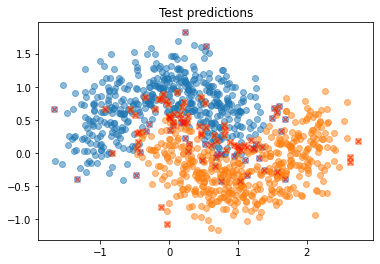

In [27]:
# Plot predictions
# Color indicates the correct class, crossed out samples are the ones which our model gets wrong.
fig, ax = plt.subplots()
ax.scatter(X_test[y_test == -1][:, 0], X_test[y_test == -1][:, 1], alpha=0.5)
ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], alpha=0.5)
ax.scatter(
    X_test[y_test != np.sign(pred_test)][:, 0],
    X_test[y_test != np.sign(pred_test)][:, 1],
    alpha=0.5, marker='x', color='r')
ax.set_title("Test predictions");

As before we are particularly interested in measuring the **efficiency** of the code.
Here you should fill in the blanks to measure the time it takes to 
 1. train the model
 2. make predictions on the test set

In [28]:
# Time the model training and predictions
krr_model = KernelRidge(kernel_bandwidth, regularization)

t_s = time.time()
krr_model.fit(X_train, y_train)
t_e = time.time()
krr_fit_time = t_e - t_s

t_s = time.time()
krr_model.predict(X_test)
t_e = time.time()
krr_pred_time = t_e - t_s

print(f"KRR timings: fit={krr_fit_time:.2}s  predict={krr_pred_time:.2}s")

KRR timings: fit=0.079s  predict=0.031s


### Nystrom Kernel Ridge Regression

Nystrom KRR is an approximation to the full KRR model which uses the Nystrom approximation instead of building the full kernel matrix.

Denote by $\tilde{X}_m$ the *Nystrom inducing points*: the subset of the dataset which is used to build $A$ (see the first part of this lab). For convenience, we will denote the kernel between the Nystrom centers by $K_{mm}$.
Similarly, we will denote the kernel between the Nystrom centers and the full dataset (which we called $[A \vert S]$ before) $K_{mn}$.

Then the Nystrom approximation tells us that
$$
    \tilde{K} = K_{mn}^\top K_{mm}^{-1} K_{mn} \approx K.
$$
If we replace $K$ for $\tilde{K}$ in the expressions for kernel ridge regression we obtain the Nystrom KRR estimator.

<font color="red">TODO: Is this true? Dimensions clearly don't match but then why are they different?</font>

A more computationally efficient way of obtaining the N-KRR estimator is through an optimization problem in the space $\mathcal{H}_m = \mathrm{span}\{k(\tilde{x}_1, \cdot), \dots, k(\tilde{x}_m, \cdot)\}$.

$$
\tilde{f} = \arg\min_{f\in\mathcal{H}_m} \sum_{i=1}^n (f(x_i) - y_i)^2 + \lambda \lVert f \rVert
$$

where the representer theorem in the new space gives (for every $f\in\mathcal{H}_m$)
$$
    f(x) = \sum_{i=1}^m \alpha_i k(x, \tilde{x}_i)
$$

Once again, you can differentiate the objective and set the derivative to zero to obtain a closed-form for $\tilde{f}$:
$$
\tilde{f}(x) = k(x, \tilde{X}_m) \tilde{\alpha}, \quad \tilde{\alpha} = (K_{mn} K_{nm} + \lambda K_{mm})^{-1} K_{mn} Y
$$

We will implement this formula in the `NystromKernelRidge` class below. Notice that now we must additionally take a parameter `m` indicating how many centers to pick.


In [29]:
class NystromKernelRidge:
    def __init__(self, kernel_bandwidth, regularization, m):
        self.kernel_gamma = 1 / (2 * kernel_bandwidth ** 2)
        self.regularization = regularization
        self.m = m
    
    def fit(self, X, y):
        # Randomly pick the Nystrom centers
        nys_ids = np.random.permutation(X.shape[0])[:self.m]
        nys_centers = X[nys_ids]
        
        # Compute the kernel matrices
        Kmm = sklearn.metrics.pairwise.pairwise_kernels(
            nys_centers, nys_centers, metric="rbf", gamma=self.kernel_gamma)
        Kmn = sklearn.metrics.pairwise.pairwise_kernels(
            nys_centers, X, metric="rbf", gamma=self.kernel_gamma)
        
        # TODO: Fill in to a) build the linear system and b) solve it.
        to_inv = Kmn @ Kmn.T + self.regularization * Kmm
        alpha = np.linalg.solve(to_inv, Kmn @ y)
        
        self.alpha_ = alpha
        self.nys_centers_ = nys_centers
        return self
    
    def predict(self, X_test):
        k_predict = sklearn.metrics.pairwise.pairwise_kernels(
            X_test, self.nys_centers_, metric="rbf", gamma=self.kernel_gamma)
        return k_predict @ self.alpha_
        

Use the N-KRR model to train and predict on the same data. Does the error change? By how much?

In [30]:
nkrr_model = NystromKernelRidge(kernel_bandwidth, regularization, m=100)
nkrr_model.fit(X_train, y_train);

# TODO: Fill in model predictions
pred_train = nkrr_model.predict(X_train)
pred_test = nkrr_model.predict(X_test)

print("Training error: %.2f%%" % (binary_classif_error(y_train, pred_train) * 100))
print("Test error: %.2f%%" % (binary_classif_error(y_test, pred_test) * 100))

Training error: 11.60%
Test error: 10.40%


Of course we are also interested in the efficiency. Fill in the code to time fit and predict phases of the N-KRR algorithm. TODO add fill-in

In [31]:
# Time the model training and predictions
nkrr_model = NystromKernelRidge(kernel_bandwidth, regularization, m=100)

t_s = time.time()
nkrr_model.fit(X_train, y_train)
t_e = time.time()
nkrr_fit_time = t_e - t_s

t_s = time.time()
nkrr_model.predict(X_test)
t_e = time.time()
nkrr_pred_time = t_e - t_s

print(f"Nystrom KRR timings: fit={nkrr_fit_time:.2}s  predict={nkrr_pred_time:.2}s")

Nystrom KRR timings: fit=0.028s  predict=0.0044s


### Quantitative Error/Time Analysis

To quantify the tradeoff between faster and more accurate algorithms, we train N-KRR with different values of `m` and plot the test error and training time.

Unfortunately, especially when `m` is small there can be a lot of *variance* in the results. Depending on how the Nystrom centers are chosen, you could have a good or a very bad model. 
To reduce the variance, 
**adapt the following code to run multiple repetitions and plot the mean error and time.**

In [32]:
m_list = np.linspace(2, 50, 20, dtype=int)
nkrr_errors = []
nkrr_timings = []
for m in m_list:
    it_err, it_time = [], []
    for i in range(20):
        nkrr_model = NystromKernelRidge(kernel_bandwidth, regularization, m=m)
        t_s = time.time()
        nkrr_model.fit(X_train, y_train)
        pred_test = nkrr_model.predict(X_test)
        t_e = time.time()
        it_err.append(binary_classif_error(y_test, pred_test))
        it_time.append(t_e - t_s)
    nkrr_errors.append(np.mean(it_err))
    nkrr_timings.append(np.mean(it_time))
    print(f"{m} centers: N-KRR error={nkrr_errors[-1] * 100:.1f}%  time={nkrr_timings[-1]:.2f}s")

2 centers: N-KRR error=31.9%  time=0.00s
4 centers: N-KRR error=14.8%  time=0.00s
7 centers: N-KRR error=11.1%  time=0.00s
9 centers: N-KRR error=10.1%  time=0.00s
12 centers: N-KRR error=9.7%  time=0.00s
14 centers: N-KRR error=9.6%  time=0.00s
17 centers: N-KRR error=9.2%  time=0.01s
19 centers: N-KRR error=9.1%  time=0.01s
22 centers: N-KRR error=8.9%  time=0.01s
24 centers: N-KRR error=8.9%  time=0.00s
27 centers: N-KRR error=8.8%  time=0.00s
29 centers: N-KRR error=8.8%  time=0.01s
32 centers: N-KRR error=8.8%  time=0.00s
34 centers: N-KRR error=8.8%  time=0.00s
37 centers: N-KRR error=8.8%  time=0.01s
39 centers: N-KRR error=8.9%  time=0.01s
42 centers: N-KRR error=8.9%  time=0.01s
44 centers: N-KRR error=9.2%  time=0.01s
47 centers: N-KRR error=8.9%  time=0.01s
50 centers: N-KRR error=9.0%  time=0.01s


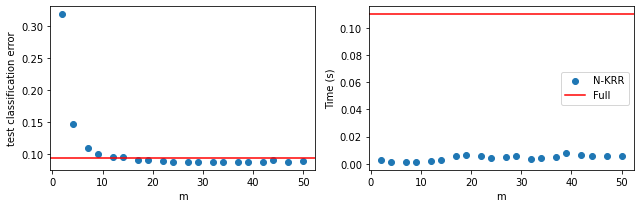

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
ax[0].scatter(m_list, nkrr_errors, label="N-KRR")
ax[0].set_xlabel("m")
ax[0].set_ylabel("test classification error")
ax[0].axhline(y=krr_test_err, label="KRR", c="r")

ax[1].scatter(m_list, nkrr_timings, label="N-KRR")
ax[1].set_xlabel("m")
ax[1].set_ylabel("Time (s)")
ax[1].axhline(y=krr_fit_time + krr_pred_time, label="Full", c='r')
ax[1].legend()
fig.tight_layout()

## Random Fourier Features

Another algorithm for efficient kernel regresion is *Random Fourier Features*.

Taking a step back, every RKHS $\mathcal{H}$ comes with a feature map $\phi$ such that $\phi(x)\in\mathcal{H}$ and $\langle \phi(x), \phi(x') \rangle_\mathcal{H} = k(x, x')$.

For common choices of RKHSs, such as the one induced by the Gaussian kernel, $\mathcal{H}$ is infinite-dimensional and thus we cannot compute $\phi(x)$ exactly. 
The idea of random feature expansions is to approximate $\phi(x)$ by a finite-dimensional expansion
$$
    z(x) = [z_1(x), \dots, z_r(x)]^\top
$$
such that $z(x)^\top z(x') \approx \phi(x)^\top \phi(x') = k(x, x')$. $r$ is the number of random features, and as $r$ increases the approximation will get more precise.

For supervised learning the features $z(x)$ can be used instead of $x$ to train a linear regression model, which is what we will do below in the `RFFRegression` class.

But first, let's have a look at $z$ for the case of the Gaussian kernel:
$$
z_i(x) = \big[\cos(x^\top w_i) \vert \sin(x^\top w_i)\big], \quad w_i \sim \mathcal{N}(0, I)
$$

Then we need to sample $w_i$ from the standard Gaussian distribution for every random feature, multiply it by the data and take sines and cosines. If $x_i \in \mathbb{R}^d$, the transformed data point is $z(x_i) \in \mathbb{R}^{2r}$, where typically $r \gg d$ so the dimension of the data increases. As long as $r < n$ however, solving the RFF problem remains cheaper than full KRR.

As before, we generate random data from the moons dataset and split it into training and test sets.

In [34]:
X, y = create_random_data(n_samples=2000, noise_level=.3, dataset="moons")
print("%d samples, %d features" % X.shape)

2000 samples, 2 features


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True, random_state=42)

The `RFFMap` class implements random Fourier features for the Gaussian kernel. Once fitted it can be used to transform the dataset.

In the `fit` method, we initialize the Gaussian weights (one per random feature requested).

In the `transform` method we compute the random feature on some input dataset.

In [36]:
class RFFMap:
    def __init__(self, num_features, kernel_bandwidth):
        self.num_features = num_features // 2  # divide by 2 since we concatenate cos and sin features.
        self.kernel_bandwidth = kernel_bandwidth
    
    def fit(self, X):
        self.W_ = np.random.randn(X.shape[1], self.num_features) / self.kernel_bandwidth
        return self
        
    def transform(self, X):
        X = X @ self.W_
        Z = np.concatenate([np.cos(X), np.sin(X)], axis=1)
        return Z / np.sqrt(self.num_features)  # normalization
    
    def fit_transform(self, X):
        """Fit and transform in a single function"""
        self.fit(X)
        return self.transform(X)

As before with the Nystrom kernel we compare the RFF kernel with the full kernel.

In [37]:
# Compute the full kernel. 
# Note that `gamma` and `lengthscale` are different parameterizations:
#   gamma = 1 / (2 * lengthscale)
full_kernel = sklearn.metrics.pairwise.pairwise_kernels(
    X, X, metric='rbf', gamma=1/2)

In [40]:
# Initialize the RFFMap class with 100 features and lengthscale equals to 1. 
# Transform the data, and compute the approximate kernel
rff_feature = RFFMap(num_features=100, kernel_bandwidth=1)
rf = rff_feature.fit_transform(X)
K_rf = rf @ rf.T

In [41]:
print(f"RFF approximation error: {kernel_approximation_error(K_rf, full_kernel)}")

RFF approximation error: 129.0393792086251


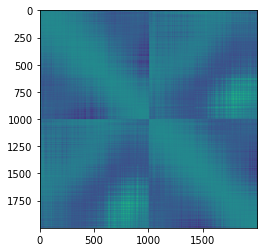

In [42]:
fig, ax = plt.subplots()
ax.imshow(K_rf - full_kernel)

The approximation error is noticeably worse than that of Nystrom, but how will RFF fare when doing regression?

In the following cell you'll have to implement the following algorithm (in the `fit` method)
 1. Compute the features using `self.rff_map`. Note that the feature transformer must be fitted first! This will give you $Z$ from $X$.
 2. Compute the covariance: $Z^\top Z$
 3. Regularize the covariance ($Z^\top Z + \lambda I$)
 4. Solve the following linear system for $\alpha$: $\alpha = (Z^\top Z + \lambda I)^{-1} Z^\top Y$
 
The predict method is similar to what we've seen before:
 1. Transform the data using `self.rff_map`. Note that the feature transformer **has already been fitted**. Don't fit it again.
 2. Compute the product $Z \alpha$.

In [45]:
class RFFRegression:
    def __init__(self, kernel_bandwidth, regularization, num_features):
        self.regularization = regularization
        self.rff_map = RFFMap(num_features, kernel_bandwidth)
    
    def fit(self, X, y):
        Z = self.rff_map.fit_transform(X)
        
        # Linear regression on the transformed data
        cov = Z.T @ Z
        reg_cov = cov + self.regularization * np.eye(cov.shape[0])
        
        alpha = np.linalg.solve(reg_cov, Z.T @ y)
        self.alpha_ = alpha
    
    def predict(self, X):
        Z = self.rff_map.transform(X)
        return Z @ self.alpha_

Now it's time to test the model on our data!

In [46]:
rff_model = RFFRegression(1, 1e-6, num_features=300)
rff_model.fit(X_train, y_train);

In [47]:
# TODO: Fill in model predictions
pred_train = rff_model.predict(X_train)
pred_test = rff_model.predict(X_test)

print("Training error: %.2f%%" % (binary_classif_error(y_train, pred_train) * 100))
print("Test error: %.2f%%" % (binary_classif_error(y_test, pred_test) * 100))

Training error: 8.00%
Test error: 9.00%


Even though the kernel approximation was not great, RFF manages to obtain similar error to the full and Nystrom KRR models.

As a final task, try to plot how the error and timings change as the number of random features changes. You can use a similar template as what was used in the previous parts of this lab.

In [48]:
# TODO: Error and Timings for RFF model as the number of random features increases